In [1]:
import os
import json
import time
import copy
from copy import deepcopy
from collections import defaultdict

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models

from skimage import io

import matplotlib.pyplot as plt
from matplotlib import patches, patheffects

import imgaug as ia
from imgaug import augmenters as iaa

from sklearn.model_selection import train_test_split

from tqdm import tqdm

In [3]:
# PATH_ANNO = r'../input/pascal_voc/PASCAL_VOC/pascal_train2007.json'
# PATH_IMG = r'../input/voctrainval_06-nov-2007/VOCdevkit/VOC2007/JPEGImages'
PATH_ANNO = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/pascal_train2007.json'
PATH_IMG = r'/home/spacor/fastai/courses/dl2/data/PASCAL_VOC/VOCdevkit/VOC2007/JPEGImages'

In [4]:
def get_img_annotations(path_annotations):
    anno_raw=json.load(open(path_annotations))
    imgId_anno_map = defaultdict(list)
    for i in anno_raw['annotations']:
        imgId_anno_map[i['image_id']].append(i)
    img_anno = []
    for i in anno_raw['images']:
        tmp_anno = imgId_anno_map[i['id']]
        tmp_rcd = i
        tmp_rcd['annotation'] = tmp_anno
        img_anno.append(tmp_rcd)
    return img_anno

def transform_anno(raw_annotations):
    transformed_annotations = []
    for raw_annotation in raw_annotations:
        tmp_anno = {'filename': raw_annotation['file_name'],
                   'bboxes': [{'bbox': i['bbox'], 'category_id': i['category_id']} for i in raw_annotation['annotation']]
                   }
        transformed_annotations.append(tmp_anno)
    return transformed_annotations

def get_obj_category_mappings(path_annotations):
    anno_raw=json.load(open(path_annotations))
    catId_name_map = dict()
    for i in anno_raw['categories']:
        catId_name_map[i['id']] = i['name']
    return catId_name_map

In [5]:
img_anno = transform_anno(get_img_annotations(PATH_ANNO)) #img annotation
img_cate_map = get_obj_category_mappings(PATH_ANNO) #cat ID to cat des

max_bouding_box = int(np.array([len(i['bboxes']) for i in img_anno]).max()) #max num of bbox #max number of bounding box in sample
num_classes = len(img_cate_map) + 1 #num class, reserve 0 for background

img_anno[1]

{'filename': '000017.jpg',
 'bboxes': [{'bbox': [184, 61, 95, 138], 'category_id': 15},
  {'bbox': [89, 77, 314, 259], 'category_id': 13}]}

In [6]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

def draw_rect(ax, b):
    """
    b: bounding box (list) top left point coordinate, width, height (x, y, w, h)
    """
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

def show_img_bbs(img, bboxes, texts):
    """
    Show img alongside with all bboxes
    img: np array of image
    bboxes: list of bbox in top left point coordinate, width, height (x, y, w, h)
    texts: list of annotation (categories) of bbox
    """
    ax = show_img(img)
    for tmp_bbox, tmp_text in zip(bboxes, texts):
        bb = tmp_bbox
        draw_rect(ax, bb)
        draw_text(ax, bb[:2], tmp_text)

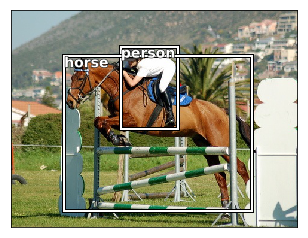

In [7]:
#test show image and bounding box
tmp = img_anno[1]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

show_img_bbs(tmp_img, tmp_bb, tmp_cat)

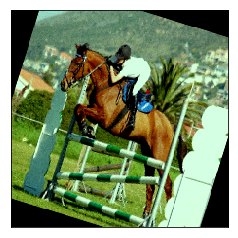

In [8]:
#Test augmentation - img only
seq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-25, 25),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)

tmp_tfm_img = seq.augment_images([tmp_img.copy(),tmp_img.copy()])
show_img_bbs(tmp_tfm_img[0], [], [])

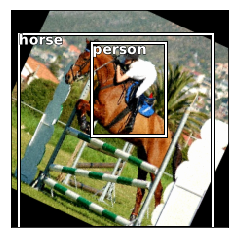

In [9]:
#Test augmentation - img + bbox
seq = iaa.Sequential([
    iaa.Scale({"height": 224, "width": 224}),
    iaa.Sequential([
        iaa.Fliplr(0.5),
        iaa.Sometimes(0.5,
            iaa.GaussianBlur(sigma=(0, 0.5))
        ),
        iaa.ContrastNormalization((0.75, 1.5)),
        iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
        iaa.Multiply((0.8, 1.2), per_channel=0.2),
        iaa.Affine(
            rotate=(-25, 25),
        )
    ], random_order=True) # apply augmenters in random order
], random_order=False)
convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y

#read raw data
tmp = img_anno[1]
tmp_img = io.imread(os.path.join(PATH_IMG, tmp['filename']))
tmp_bb = [i['bbox'] for i in tmp['bboxes']]
tmp_bb_obj = ia.BoundingBoxesOnImage([ia.BoundingBox(*convert_bb_fmt(i)) for i in tmp_bb], shape=tmp_img.shape) #convert to Boundingboxes object
tmp_cat = [img_cate_map[i['category_id']] for i in tmp['bboxes']]

#augmentation
seq_det = seq.to_deterministic()
tmp_aug_img = seq_det.augment_images([tmp_img.copy()])[0]
tmp_aug_bbs_raw = seq_det.augment_bounding_boxes([tmp_bb_obj])[0].remove_out_of_image().cut_out_of_image()

#convert back to generally accepted format
reverse_bb_fmt = lambda bb_obj: [bb_obj.x1, bb_obj.y1, bb_obj.width, bb_obj.height]
tmp_aug_bbs = [reverse_bb_fmt(i) for i in tmp_aug_bbs_raw.bounding_boxes]

#display
show_img_bbs(tmp_aug_img, tmp_aug_bbs, tmp_cat)

In [10]:
#filter largest bbox
sort_by_area = lambda bboxes: bboxes['bbox'][2] * bboxes['bbox'][3]
img_anno_largest_bbox_only = deepcopy(img_anno)
for i in img_anno_largest_bbox_only:
    i['bboxes'].sort(reverse = True, key = sort_by_area)
    i['bboxes'] = [i['bboxes'][0]]

img_anno_largest_bbox_only[:5]

[{'filename': '000012.jpg',
  'bboxes': [{'bbox': [155, 96, 196, 174], 'category_id': 7}]},
 {'filename': '000017.jpg',
  'bboxes': [{'bbox': [89, 77, 314, 259], 'category_id': 13}]},
 {'filename': '000023.jpg',
  'bboxes': [{'bbox': [2, 1, 241, 461], 'category_id': 15}]},
 {'filename': '000026.jpg',
  'bboxes': [{'bbox': [89, 124, 248, 88], 'category_id': 7}]},
 {'filename': '000032.jpg',
  'bboxes': [{'bbox': [103, 77, 272, 106], 'category_id': 1}]}]

In [11]:
def BboxCenterTfm(bbox):
    """
    transform top left x, y w, h to center x, y w, h
    """
    topX, topY, w, h = bbox
    centerX = topX + w/2
    centerY = topY + h/2
    return (centerX, centerY, w, h)

def BboxCenterTfmReverse(bbox):
    """
    transform center x, y w, h to top left x, y w, h
    """
    centerX, centerY, w, h = bbox
    topX = centerX - w/2
    topY = centerY - h/2
    return (topX, topY, w, h)

class PascalDataset(Dataset):
    def __init__(self, img_meta, transform = None):
        self.img_meta = img_meta
        self.transform = transform
        
    def __len__(self):
        return len(self.img_meta)
    
    def __getitem__(self, idx):
        
        img = io.imread(os.path.join(PATH_IMG, self.img_meta[idx]['filename']))
        bboxes = [i['bbox'] for i in self.img_meta[idx]['bboxes']]
        categories = [i['category_id'] for i in self.img_meta[idx]['bboxes']]
        
        if bool(self.transform) is True:
            img_boxes = (img, bboxes)
            img, bboxes = self.transform(img_boxes)
        
#         categories = categories[0] #largest boxes only
        categories = torch.tensor(categories)
        
        if len(bboxes) > 0:
            bboxes = bboxes[0] #largest boxes only
        
        output = (img, (bboxes, categories))
        return output

class ImgBBoxTfm:
    def __init__(self, output_size = 224, aug_pipline = None):
        self.output_size = output_size
        self.seq = aug_pipline
    
    def __call__(self, img_boxes):
        """
        img_boxes: tuple of image, bboxes. bboxes are array of bbox
        """
        img, bboxes = img_boxes
        convert_bb_fmt = lambda bb: [bb[0], bb[1], bb[0] + bb[2], bb[1] + bb[3]] #convert topleft xy, wh to min x, min y, max x,  max y
        reverse_bb_fmt = lambda bb_obj: [bb_obj.x1_int, bb_obj.y1_int, int(bb_obj.width), int(bb_obj.height)]
        
        raw_image = img
        raw_bbs = ia.BoundingBoxesOnImage([
            ia.BoundingBox(*convert_bb_fmt(bb)) for bb in bboxes
        ], shape=raw_image.shape)
        
        seq_det = self.seq.to_deterministic()
        image_aug = seq_det.augment_images([raw_image])[0]
        bbs_aug = seq_det.augment_bounding_boxes([raw_bbs])[0].remove_out_of_image().cut_out_of_image()
        bbs_aug = [BboxCenterTfm(reverse_bb_fmt(bb)) for bb in bbs_aug.bounding_boxes]
        if len(bbs_aug) == 0:
            print('bbox empty')
            bbs_aug = [[0,0,0,0]] #in case all aug bboxes are outside of the img and got removed
        img_boxes = (image_aug, bbs_aug)
        return img_boxes

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, img_boxes):
        img, bboxes = img_boxes
        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        img = np.clip(img, a_min=0, a_max=None)
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img).float().div(255)
        bboxes = torch.from_numpy(np.array(bboxes)).float()
        img_boxes = (img, bboxes)
        return img_boxes

class NormalizeImg:
    def __init__(self):
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
        
    def __call__(self, img_boxes):
        img, bboxes = img_boxes
        img = self.normalize(img)
        bboxes = bboxes.div(IMG_SIZE) #normalizing bbox beteeen 0-1
        img_boxes = (img, bboxes)
        return img_boxes

In [12]:
def get_aug_pipline(img_size, mode = 'train'):
    if mode == 'train':
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
            iaa.Sequential([
                iaa.Fliplr(0.5),
                iaa.Sometimes(0.5,
                    iaa.GaussianBlur(sigma=(0, 0.5))
                ),
                iaa.ContrastNormalization((0.75, 1.5)),
                iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
                iaa.Multiply((0.8, 1.2), per_channel=0.2),
                iaa.Affine(
                    rotate=(-25, 25),
                )
            ], random_order=True) # apply augmenters in random order
        ], random_order=False)
    else: #ie.val
        seq = iaa.Sequential([
            iaa.Scale({"height": img_size, "width": img_size}),
        ], random_order=False)
    return seq

In [13]:
def inverse_transform(img_torch):
    """denormalize and inverse transform"""
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
        std=[1/0.229, 1/0.224, 1/0.255]
    )
    tmp = deepcopy(img_torch)
    inv_normalize(tmp)
    tmp = np.clip((tmp.numpy().transpose((1,2,0)) * 255), a_min=0, a_max=255).astype(np.int)
    return tmp

In [14]:
IMG_SIZE = 224
BATCH_SIZE = 16
VAL_SIZE =0.33

train_set, val_set = train_test_split(img_anno_largest_bbox_only, test_size=VAL_SIZE, random_state=42)

composed = {}
composed['train'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'train')), 
                                     ToTensor(), 
                                     NormalizeImg()])
composed['val'] = transforms.Compose([ImgBBoxTfm(output_size=IMG_SIZE, aug_pipline=get_aug_pipline(img_size=IMG_SIZE, mode = 'val')), 
                                     ToTensor(), 
                                     NormalizeImg()])

image_datasets = {'train': PascalDataset(train_set, transform=composed['train']),
                 'val': PascalDataset(val_set, transform=composed['val'])}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=1, drop_last=True)
              for x in ['train', 'val']}

In [15]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(dataset_sizes)

{'train': 1675, 'val': 826}


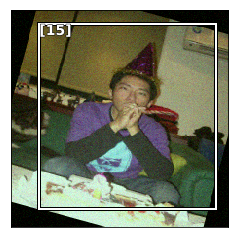

In [16]:
#test dataset and transformation pipline

reverse_bb = lambda x: x * IMG_SIZE 

tmp = image_datasets['train'][1]
tmp_img = tmp[0]
tmp_bboxes = [list(BboxCenterTfmReverse(reverse_bb(tmp[1][0].numpy())))] #reverse bb into abs val
tmp_cat = [tmp[1][1].numpy()] #for largest box

show_img_bbs(inverse_transform(tmp_img), tmp_bboxes, tmp_cat) 

In [17]:
# Get a batch of training data
inputs, targets = next(iter(dataloaders['train']))
print('bbox \n ')
print(targets[0])
print('label \n')
print(targets[1])

bbox 
 
tensor([[ 0.3728,  0.6362,  0.7455,  0.7277],
        [ 0.5000,  0.5022,  1.0000,  0.7009],
        [ 0.6875,  0.6317,  0.6161,  0.6562],
        [ 0.4911,  0.7969,  0.9821,  0.3973],
        [ 0.5156,  0.4911,  0.7009,  0.5000],
        [ 0.8259,  0.6897,  0.1696,  0.1652],
        [ 0.6696,  0.5491,  0.6607,  0.9018],
        [ 0.4821,  0.5402,  0.6071,  0.4107],
        [ 0.5179,  0.5156,  0.9554,  0.9688],
        [ 0.5000,  0.5000,  1.0000,  1.0000],
        [ 0.5312,  0.7522,  0.5893,  0.4866],
        [ 0.6116,  0.5156,  0.7768,  0.8527],
        [ 0.4442,  0.5915,  0.8080,  0.8080],
        [ 0.7031,  0.4665,  0.5938,  0.9330],
        [ 0.6250,  0.5781,  0.7411,  0.7009],
        [ 0.6786,  0.5826,  0.6429,  0.6920]])
label 

tensor([[  2],
        [  1],
        [  7],
        [ 11],
        [  7],
        [  7],
        [ 15],
        [  8],
        [  7],
        [  9],
        [ 12],
        [ 10],
        [ 15],
        [  8],
        [ 12],
        [  4]])


In [18]:
class Flatten(nn.Module):
    def __init__(self): 
        super().__init__()
    def forward(self, x): 
        return x.view(x.size(0), -1)

class Identity(nn.Module):
    """identity layer"""
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return x

# def resnetCustom():
#     resnet34 = models.resnet34(pretrained=True)
#     for param in resnet34.parameters():
#             param.require_grad = False

#     removed = list(resnet34.children())[:-2]
#     ssd_head = nn.Sequential(Flatten(), nn.Linear(25088,4), nn.Sigmoid())
#     ssd_custom = removed + list(ssd_head)
#     model = nn.Sequential(*ssd_custom)
#     return model
    
class RNetCustom(nn.Module):
    def __init__(self, num_cat):
        super().__init__()
        self.num_bbox_param = 4 
        self.num_cat = num_cat
        
        self.backbone = self._prep_backbone()
        self.flatten = Flatten()
        self.relu_1 = nn.ReLU()
        self.dropout_1 = nn.Dropout(p=0.5)
        self.fc_2 = nn.Linear(512 * 7 * 7, 256)
        self.relu_2 = nn.ReLU()
        self.batchnorm_2 = nn.BatchNorm1d(256)
        self.dropout_2 = nn.Dropout(p=0.5)
        self.fc_3 = nn.Linear(256, self.num_bbox_param + self.num_cat )
        
    def _prep_backbone(self):     
        base_model = models.resnet34(pretrained=True)
        removed = list(base_model.children())[:-2]
        backbone = nn.Sequential(*removed)
        for param in backbone.parameters():
            param.require_grad = False
        return backbone
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.flatten(x)
        x = self.relu_1(x)
        x = self.dropout_1(x)
        x = self.fc_2(x)
        x = self.relu_2(x)
        x = self.batchnorm_2(x)
        x = self.dropout_2(x)
        x = self.fc_3(x)

        y_pred = x
        return y_pred

In [19]:
def criterion(y_pred, y_true):
    loss_bbox_scaling = 20
    loss_cat_scaling = 1
    
    #prep y_true
    y_true_bboxes, y_true_categories = y_true
    y_true_bboxes = y_true_bboxes.to(device)
    y_true_categories = y_true_categories.to(device)
    y_true_categories = y_true_categories.squeeze(1)
    
    #prep y_pred
    y_pred_bboxes, y_pred_categories = y_pred[:, :4], y_pred[:, 4:]
    y_pred_bboxes = F.sigmoid(y_pred_bboxes)
    
    #calculate loss
    loss_bbox = F.mse_loss(y_pred_bboxes, y_true_bboxes) 
    loss_categories = F.cross_entropy(y_pred_categories, y_true_categories) 
#     print('raw loss_bbox {}'.format(loss_bbox))
#     print('raw loss_cat {}'.format(loss_categories))
    loss = loss_bbox * loss_bbox_scaling + loss_categories * loss_cat_scaling
    return loss

In [20]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:
#                 bboxes, categories = targets
                
#                 categories = categories.squeeze(1) #for largest item classification only
                inputs = inputs.to(device)
#                 bboxes = bboxes.to(device)
#                 categories = categories.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
#                     _, preds = torch.max(outputs, 1)
#                     loss = criterion(outputs, categories)
                    loss = criterion(outputs, targets)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
#                 running_corrects += torch.sum(preds == categories.data)

            epoch_loss = running_loss / dataset_sizes[phase]
#             epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = 0 #for bbox only training
    
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
#     model.load_state_dict(best_model_wts)
    return model

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = RNetCustom(num_cat=num_classes)
model_ft = model_ft.to(device)

# criterion = nn.MSELoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [22]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=5)

Epoch 0/4
----------
raw loss_bbox 0.06294332444667816
raw loss_cat 3.493324041366577
raw loss_bbox 0.06800132244825363
raw loss_cat 3.281590700149536
raw loss_bbox 0.07982736080884933
raw loss_cat 3.063079833984375
raw loss_bbox 0.06455513834953308
raw loss_cat 3.389843702316284
raw loss_bbox 0.06782237440347672
raw loss_cat 3.2273097038269043
raw loss_bbox 0.06464742124080658
raw loss_cat 2.989621877670288
raw loss_bbox 0.04823371767997742
raw loss_cat 2.9659507274627686
raw loss_bbox 0.054215531796216965
raw loss_cat 2.846360683441162
raw loss_bbox 0.04624014347791672
raw loss_cat 2.948169231414795
raw loss_bbox 0.06724389642477036
raw loss_cat 2.807943105697632
raw loss_bbox 0.05070251226425171
raw loss_cat 2.8754072189331055
raw loss_bbox 0.05744512379169464
raw loss_cat 2.772664785385132
raw loss_bbox 0.06040270999073982
raw loss_cat 2.9516208171844482
raw loss_bbox 0.02891886606812477
raw loss_cat 2.8880770206451416
raw loss_bbox 0.0413188710808754
raw loss_cat 2.460564851760864

In [99]:
# take a look at module output
inputs, targets = next(iter(dataloaders['val']))

In [100]:
targets[0].shape

torch.Size([16, 4])

In [101]:
with torch.no_grad():
    inputs = inputs.to(device)
    y_pred = model_ft(inputs)

inputs = inputs.cpu()
output = y_pred.cpu().numpy()

In [102]:
# custom function
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)


In [125]:
ix = 11

tmp_img = inputs[ix]
tmp_y_pred = output[ix]

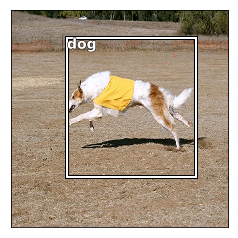

In [126]:
y_pred_bbox = tmp_y_pred[:4]
y_pred_bbox = [list(BboxCenterTfmReverse(reverse_bb(sigmoid_v(y_pred_bbox))))]

y_pred_cate = tmp_y_pred[4:]
y_pred_cate = [img_cate_map[y_pred_cate.argmax()]]

show_img_bbs(inverse_transform(tmp_img), y_pred_bbox, y_pred_cate) 